In [25]:
import h5py
import numpy as np
import os
import json
import labelme
import torch
import pickle

import torchvision.transforms as T
import torchvision.transforms.functional as F

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [27]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))

In [2]:
from show import *
from dataset import *

In [3]:
label_name_to_value = {
    '_background_': 0,
    'door':1,
    'object':2,
    'wall': 3,
    'window': 4,
}

In [4]:
img_dir = 'data/labels'
img_paths = [os.path.join(img_dir, fname) for fname in sorted(os.listdir(img_dir))]
img_paths = [path for path in img_paths]

img_paths[:5]

['data/labels/AD0008.json',
 'data/labels/AD0012.json',
 'data/labels/AD0021.json',
 'data/labels/AD0024.json',
 'data/labels/AD0025.json']

In [5]:
def path_to_image(img_path):
    data = json.load(open(img_path))

    imageData = data['imageData']
    img = labelme.utils.img_b64_to_arr(imageData)
    #print(img.shape)

    img = (img / 255).astype('float32')

    return img

def path_to_label(img_path, img_shape):
    data = json.load(open(img_path))
    
    for shape in sorted(data['shapes'], key=lambda x: x['label']):
        label_name = shape['label']
        if label_name == 'objet':
            shape['label'] = 'object'
            label_name = shape['label']
        label_value = label_name_to_value[label_name]
        
    lbl = labelme.utils.shapes_to_label(img_shape, data['shapes'], label_name_to_value)
    lbl = lbl.astype('uint8')[:, :, np.newaxis]
    return lbl

def path_to_shape(img_path):
    return labelme.utils.img_b64_to_arr(json.load(open(img_path))['imageData']).shape

In [6]:
def path_to_tuple(img_path):
    data = json.load(open(img_path))

    imageData = data['imageData']
    img = labelme.utils.img_b64_to_arr(imageData)
    
    for shape in sorted(data['shapes'], key=lambda x: x['label']):
        label_name = shape['label']
        if label_name == 'objet':
            shape['label'] = 'object'
            label_name = shape['label']
        label_value = label_name_to_value[label_name]
        
    lbl = labelme.utils.shapes_to_label(img.shape, data['shapes'], label_name_to_value)
    lbl = lbl.astype('uint8')[:, :, np.newaxis]
    
    return img, lbl
    

In [7]:
%timeit path_to_image(img_paths[0])

428 ms ± 4.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit path_to_label(img_paths[0], (2048, 3072, 3))

104 ms ± 2.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%timeit path_to_shape(img_paths[0])

298 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit path_to_tuple(img_paths[0])

387 ms ± 8.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
# too long to run again
# shapes = [path_to_shape(p) for p in tqdm(img_paths)]
# pickle.dump(shapes, open("data/shapes.p", "wb" ))
shapes = pickle.load(open("data/shapes.p", "rb" ))
shapes[:5]

[(2048, 3072, 3),
 (2048, 3072, 3),
 (2048, 3072, 3),
 (2048, 3072, 3),
 (2048, 3072, 3)]

In [12]:
patch_size = 256
max_size = 1024

In [13]:
def to_multiple_of_shape(x, y, m=patch_size, max_size=max_size):
    n_x = x // m
    n_y = y // m
    n_max_size = max_size // m
    
    if n_x > n_max_size and n_x > n_y:
        n_x = n_max_size
        n_y = round(y * n_max_size / x)
    else:
        n_y = n_max_size
        n_x = round(x * n_max_size / y)
        
    return (n_x * m, n_y * m)

In [14]:
better_shapes = [to_multiple_of_shape(s[0], s[1]) for s in shapes]

In [15]:
better_shapes[:5]

[(768, 1024), (768, 1024), (768, 1024), (768, 1024), (768, 1024)]

In [16]:
def to_square_crops(x, y, size=patch_size):
    assert x % size == 0
    assert y % size == 0
    crops = []
    for i in range(x//size):
        for j in range(y//size):
            crops.append((i * size, j * size))
    return crops

In [17]:
crops = [to_square_crops(s[0], s[1]) for s in better_shapes]
len(crops[0]), crops[0]

(12,
 [(0, 0),
  (0, 256),
  (0, 512),
  (0, 768),
  (256, 0),
  (256, 256),
  (256, 512),
  (256, 768),
  (512, 0),
  (512, 256),
  (512, 512),
  (512, 768)])

In [18]:
pickle.dump([len(c) for c in crops], open("data/crops_{}.p".format(patch_size), "wb" ))

In [19]:
total_num_crops = len([a for b in crops for a in b])
total_num_crops

4996

In [20]:
to_multiple_of_shape(*(3072, 2048))

(1024, 768)

In [21]:
data_transforms = T.Compose([
    T.ToTensor(),
    T.ToPILImage(),
    T.Lambda(lambda img: T.Resize(to_multiple_of_shape(*img.size[::-1], m=patch_size, max_size=max_size))(img)),
    T.Lambda(lambda img: [F.crop(img, i, j, patch_size, patch_size) for (i, j) in to_square_crops(*img.size[::-1], size=patch_size)]),
    T.Lambda(lambda crops: (torch.stack([T.ToTensor()(crop) for crop in crops]) * 255).int()),
])

In [22]:
img_tmp = data_transforms(path_to_image(img_paths[0]))
img_tmp.shape

torch.Size([12, 3, 256, 256])

In [23]:
img_grid = utils.make_grid(img_tmp, nrow=4)
img_grid.shape

torch.Size([3, 776, 1034])

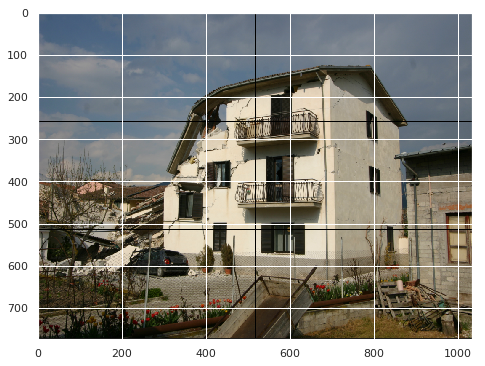

In [28]:
show_img(img_grid)

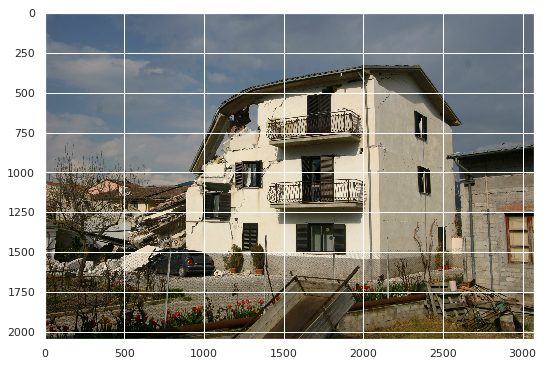

In [29]:
show_img(path_to_image(img_paths[0]))

# Images from .json to .hdf5

In [30]:
img_shape = (3, patch_size, patch_size)
n_img = len(img_paths)

print(img_shape, n_img)

(3, 256, 256) 418


In [31]:
dset = BuildingsDatasetH5("data/images_{}.hdf5".format(patch_size))

In [32]:
i = 6
img = dset[i]['image']
lbl = dset[i]['label']

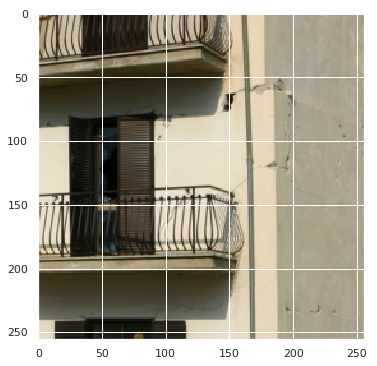

In [33]:
show_img(img)

(256, 256, 3) (256, 256, 1)


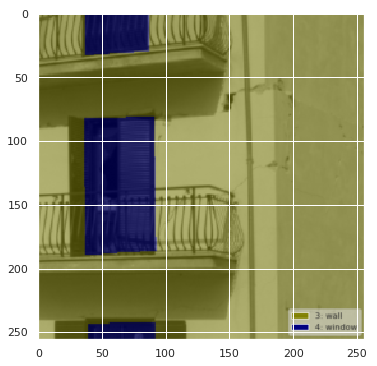

In [34]:
show_labeled_img(img, lbl, label_name_to_value)

In [35]:
%timeit [dset[i] for i in range(img_tmp.shape[0])]

19.8 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
